In [225]:
# !pip3 install pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
import os
import json
import tikzplotlib
from functools import partial

plt.style.use('default')
BASE_DIR = '/Users/dfilipiak/repositories/publikacje/PUB-2021-OneShotKG'
PROJECT_DIR = f'{BASE_DIR}/KGTN2'
FIGURES_DIR = f'{BASE_DIR}/figures'

Parse all results and load it to DataFrame.

In [226]:
def parse_results(resultsdir, repr, lr, wd, printing=False, stds_intead_of_means=False):
    outpath = '{}_' + 'lr_{:.3f}_wd_{:.3f}'.format(lr, wd) + '_expid_{:d}_lowshotn_{:d}.json' 
    lowshotns = [1,2,5, 10]
    expids = [1,2,3,4,5]
    all_nums = np.zeros((len(lowshotns), len(expids), 4))
    for i, ei in enumerate(expids):
        for j, ln in enumerate(lowshotns):
            outfile = os.path.join(resultsdir, outpath.format(repr, ei, ln))
            with open(outfile, 'r') as f:
                out = json.load(f)
                all_nums[j,i,:] = np.array(out['accs'])*100

    if stds_intead_of_means:
        means = np.std(all_nums, axis=1)
    else:
        means = np.mean(all_nums, axis=1)

    if printing:
        print('n \tNovel17 Novel18 All    All with prior')
        print('  \tTop-5   Top-5   Top-5  Top-5')
        
        print('='*80)

        to_print = '\n'.join([str(lowshotns[i])+'\t'+'\t'.join(['{:.2f}'.format(x) for x in y]) for i, y in enumerate(means)])
        print(to_print)
        print('='*80)
        mean_mean = np.mean(means, axis=0)
        print('mean\t'+'\t'.join(['{:.2f}'.format(x) for x in mean_mean]))
    else:
        results = means[:, 1:3].transpose()
        
        novel = {k: v for k, v in zip(lowshotns, results[0].squeeze())}
        novel['type'] = 'novel'
        novel['label'] = resultsdir
        
        all = {k: v for k, v in zip(lowshotns, results[1].squeeze())}
        all['type'] = 'all'
        all['label'] = resultsdir

        return novel, all

In [291]:
def __add_experiment_paths(experiment_paths, feature_extractor, lr=0.01, wd=0.0001, baseline_lr=0.1, stds_intead_of_means=False):
    results = []
    for experiment_path in experiment_paths:
        current_lr = baseline_lr if experiment_path.rsplit("/", 1)[-1] == "baseline" else lr
        r_novel, r_all = parse_results(experiment_path, feature_extractor, current_lr, wd, stds_intead_of_means=stds_intead_of_means)
        results.append(r_novel), results.append(r_all)

    return pd.DataFrame(results)

def __replace_labels(df, aggregation_function, similarity_function):
    df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
    df['label'] = df['label'].replace([f'{similarity_function}'], 'KGTN (g)')
    df['label'] = df['label'].replace([f'hierarchy,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (h+g)')
    df['label'] = df['label'].replace([f'wiki,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+g)')
    df['label'] = df['label'].replace([f'wiki,hierarchy-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+h)')
    df['label'] = df['label'].replace([f'wiki,hierarchy,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+h+g)')
    # df = df.set_index(['type', 'label'])
    return df

def get_experiment_df(experiment_paths, feature_extractor, aggregation_function, similarity_function, stds_intead_of_means=False, store_additional_description=False):
    df = __add_experiment_paths(experiment_paths, feature_extractor, stds_intead_of_means=stds_intead_of_means)
    df = __replace_labels(df, aggregation_function, similarity_function)
    if store_additional_description:
        df['feature_extractor'] = feature_extractor
        df['aggregation_function'] = aggregation_function
        df['similarity_function'] = similarity_function
    return df

def get_diff_between_baseline_and_experiments(df, baseline_name, experiment_family_prefix):
    # Diff between baseline and the best ensemble in categroy     
    df_1 = df[df.label.str.startswith(experiment_family_prefix)].groupby(df.type).max().drop('label', axis=1).set_index('type')    
    df_2 = df[df.label == baseline_name].groupby(df.type).max().drop('label', axis=1).set_index('type')
    diff = df_1.subtract(df_2).round(2)
    return diff

def plot_comparisons(df, fig_name_prefix=False):
    labels = ["1", "2", "5", "10"]

    for current_type in ['novel', 'all']:
        plt.figure(figsize=(10,7))
        for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
            plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
            plt.legend(loc='lower right')
            plt.title(f'Subset: {current_type}')
            plt.ylabel('Top-5 accuracy')
            plt.xlabel('k')

    
        if fig_name_prefix:
            tikzplotlib.save(f"{FIGURES_DIR}/{fig_name_prefix}_{current_type}.tex")
        plt.show()


def plot_comparisons_with_errorbards(df, df_std_mean, models_to_print, fig_name_prefix=False, figsize=(5,8), exp_scale_functions=False, fix_matplotlib=False):
    labels = ["1", "2", "5", "10"]

    df_subset = df[df.label.isin(models_to_print)]
    df_std_subset = df_std_mean[df_std_mean.label.isin(models_to_print)]

    
    for current_type in ['novel', 'all']:
        plt.figure(figsize=figsize)
        errorbars = []
        for x, err in zip(df_subset[df_subset.type == current_type].iterrows(), df_std_subset[df_std_subset.type == current_type].iterrows()):
            print(x[1][:4].tolist())
            # data = np.log(x[1][:4].to_numpy().astype('float64'))
            # yerr = np.log(err[1][:4].to_numpy().astype('float64'))
            yerr = err[1][:4]
            data = x[1][:4]
            eb = plt.errorbar(labels, data, yerr=yerr, marker='o', label=x[1]['label'], capsize=5, markersize=3)
            errorbars.append(eb)
            # plt.plot(labels, x[1][:4], marker='o', label=x[1]['label'])
            # plt.yscale('log')
            if exp_scale_functions:
                ax = plt.gca()
                ax.set_yscale('function', functions=exp_scale_functions)
            plt.legend(loc='lower right')
            plt.title(f'Subset: {current_type}')
            plt.ylabel('Top-5 accuracy')
            plt.xlabel('k')

        if fig_name_prefix:
            if fix_matplotlib:
                tikzplotlib_fix_ncols(plt.gcf())
            tikzplotlib.save(f"{FIGURES_DIR}/{fig_name_prefix}_{current_type}.tex",  axis_height=f'{figsize[1]}cm', axis_width=f'{figsize[0]}cm')
            # delete all labels
            plt.gca().legend([])
            # add the desired ones  
            [eb.set_label(m) for m in models_to_print]
            # error_bar1[0].set_label('data1')

        plt.show()

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    https://stackoverflow.com/questions/75900239/attributeerror-occurs-with-tikzplotlib-when-legend-is-plotted
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [230]:
aggregation_function = "mean"
similarity_function = "InnerProduct"
experiment_name = "KGTNens-ResNet50_sgm"
feature_extractor = 'ResNet50_sgm'
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

baseline_paths = [f"{BASE_DIR}/KGTN2/results/{feature_extractor}/{s1}" for s1 in 
                    ["baseline", f'KGTN/{similarity_function}', *[f"KGTNens/{s2}-{aggregation_function}-{similarity_function}" for s2 in kgtn_ens_kgs]]]

df = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function)
df_diff = get_diff_between_baseline_and_experiments(df, 'KGTN (baseline)', 'KGTN-ens')

df_std_mean = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function, stds_intead_of_means=True)
df_std_mean = df_std_mean.set_index(['type', 'label'])

df
# print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
#     index=False, 
#     float_format="%.2f",
#     caption='Knowledge graph ensembling (sum), top-5 accuracy',
#     label='tab:ens-sum',
#     ))

,1,2,5,10,type,label
0,53.794212,67.480386,77.971704,82.317685,novel,baseline
1,61.498225,72.098619,80.310059,83.476923,all,baseline
2,61.961415,71.082958,78.533762,82.482315,novel,KGTN (baseline)
3,68.336095,75.273373,80.923866,83.396450,all,KGTN (baseline)
4,62.300965,70.451447,78.897749,82.210932,novel,KGTN-ens (h+g)
5,66.886785,73.864300,81.064300,83.222091,all,KGTN-ens (h+g)
6,60.410289,69.408360,78.805145,82.096463,novel,KGTN-ens (w+g)
7,66.067061,73.301775,81.011440,83.150296,all,KGTN-ens (w+g)
8,57.886817,67.485531,78.492605,81.912540,novel,KGTN-ens (w+h)
9,64.095464,71.830375,80.795266,83.042998,all,KGTN-ens (w+h)


In [220]:
# df_diff
# df_std_mean
# plot_comparisons(df)

# Max

In [221]:
aggregation_function = "max"
similarity_function = "InnerProduct"
experiment_name = "KGTNens-ResNet50_sgm"
feature_extractor = 'ResNet50_sgm'
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

baseline_paths = [f"{BASE_DIR}/KGTN2/results/{feature_extractor}/{s1}" for s1 in 
                    ["baseline", f'KGTN/{similarity_function}', *[f"KGTNens/{s2}-{aggregation_function}-{similarity_function}" for s2 in kgtn_ens_kgs]]]

df = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function)
df_diff = get_diff_between_baseline_and_experiments(df, 'KGTN (baseline)', 'KGTN-ens')

df_std_mean = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function, stds_intead_of_means=True)
# df_std_mean = df_std_mean.set_index(['type', 'label'])

df

# print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
#     index=False, 
#     float_format="%.2f",
#     caption='Knowledge graph ensembling (sum), top-5 accuracy',
#     label='tab:ens-sum',
#     ))

,1,2,5,10,type,label
0,53.794212,67.480386,77.971704,82.317685,novel,baseline
1,61.498225,72.098619,80.310059,83.476923,all,baseline
2,61.961415,71.082958,78.533762,82.482315,novel,KGTN (baseline)
3,68.336095,75.273373,80.923866,83.396450,all,KGTN (baseline)
4,62.733119,71.481672,78.825723,82.556913,novel,KGTN-ens (h+g)
5,68.579882,75.454832,81.117160,83.460355,all,KGTN-ens (h+g)
6,61.211576,70.662379,78.598071,82.342122,novel,KGTN-ens (w+g)
7,67.693886,75.044576,80.953057,83.327022,all,KGTN-ens (w+g)
8,58.774277,69.171704,78.442444,82.254662,novel,KGTN-ens (w+h)
9,66.167258,74.007101,80.857594,83.263905,all,KGTN-ens (w+h)


In [222]:
# df_diff

[61.961414790996784, 71.08295819935692, 78.53376205787781, 82.48231511254019]
[62.733118971061096, 71.48167202572347, 78.8257234726688, 82.55691318327975]
[61.1, 70.3, 78.6, nan]


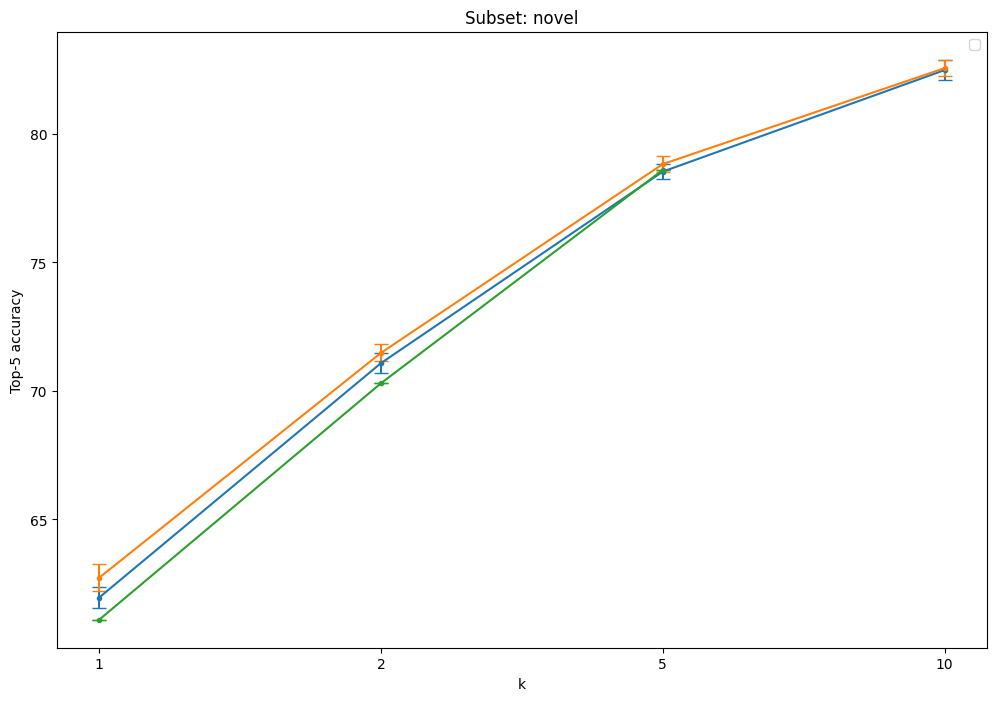

[68.33609467455622, 75.27337278106509, 80.92386587771202, 83.396449704142]
[68.57988165680473, 75.45483234714004, 81.1171597633136, 83.4603550295858]


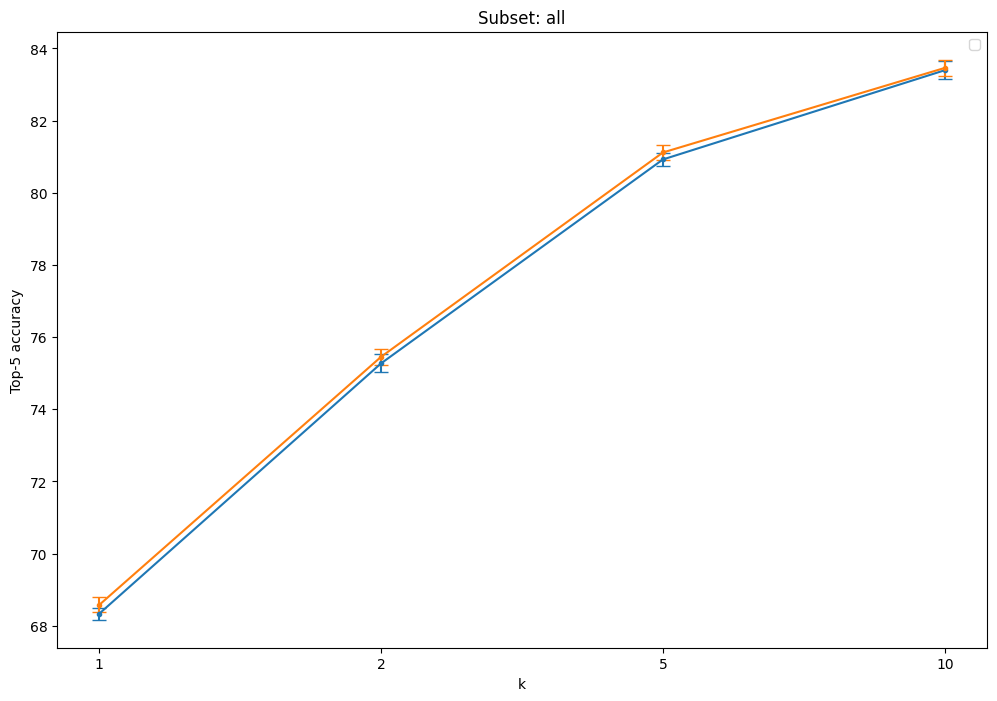

In [224]:

# plot_comparisons_with_errorbards(df, df_std_mean, ['KGTN (baseline)', 'KGTN-ens (h+g)'])
# ['KGTN (baseline)', 'KGTN-ens (h+g)']
df_shen2021 = pd.DataFrame.from_dict([{1: 61.1, 2: 70.3, 5: 78.6, 10: None, "type": "novel", "label": "SGM w. graph. reg."}])
df_shen2021_std = pd.DataFrame.from_dict([{1: 0, 2: 0, 5: 0, 10: None, "type": "novel", "label": "SGM w. graph. reg."}])

plot_comparisons_with_errorbards(
    pd.concat([df, df_shen2021], ignore_index=True), 
    pd.concat([df_std_mean, df_shen2021_std], ignore_index=True), 
    ['KGTN (baseline)', 'KGTN-ens (h+g)', "SGM w. graph. reg."],
    figsize=(12, 8),
    fig_name_prefix="max",
    fix_matplotlib=True
    # exp_scale_functions=(partial(np.power, 10.0), np.log10),
    )
# df


# ResNet10/18-sgm

In [292]:
aggregation_function = "max"
similarity_functions = ["InnerProduct", "CosSim"]
feature_extractors = ['ResNet10_sgm', 'ResNet18_sgm']
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

dfs = []
for fe in feature_extractors:
    baseline_path = f"{BASE_DIR}/KGTN2/results/{fe}/baseline"
    dfs.append(get_experiment_df([baseline_path], fe, None, "-", store_additional_description=True))
    for sf in similarity_functions:
        paths = [f"{BASE_DIR}/KGTN2/results/{fe}/KGTN/{sf}"]
        paths += [f"{BASE_DIR}/KGTN2/results/{fe}/KGTNens/{kg}-{aggregation_function}-{sf}" for kg in kgtn_ens_kgs]
        dfs.append(get_experiment_df(paths, fe, aggregation_function, sf, store_additional_description=True))
        
df = pd.concat(dfs, ignore_index=True)
df

,1,2,5,10,type,label,feature_extractor,aggregation_function,similarity_function
0,43.915113,56.183923,69.463666,73.936977,novel,baseline,ResNet10_sgm,None,-
1,47.431164,55.938462,67.983432,71.209467,all,baseline,ResNet10_sgm,None,-
2,44.484887,53.587138,68.309968,71.354341,novel,KGTN (g),ResNet10_sgm,max,InnerProduct
3,45.499803,54.760552,69.236292,71.143984,all,KGTN (g),ResNet10_sgm,max,InnerProduct
4,43.882958,54.196785,68.763987,72.342122,novel,KGTN-ens (h+g),ResNet10_sgm,max,InnerProduct
5,45.931361,56.457594,70.410256,72.650099,all,KGTN-ens (h+g),ResNet10_sgm,max,InnerProduct
6,41.886817,51.858521,68.533762,71.373633,novel,KGTN-ens (w+g),ResNet10_sgm,max,InnerProduct
7,44.888363,54.261144,69.830375,71.731755,all,KGTN-ens (w+g),ResNet10_sgm,max,InnerProduct
8,40.141479,50.612219,68.178778,71.747910,novel,KGTN-ens (w+h),ResNet10_sgm,max,InnerProduct
9,43.001183,53.185799,69.958185,72.264300,all,KGTN-ens (w+h),ResNet10_sgm,max,InnerProduct


In [293]:
df_pivot = pd.pivot_table(
    df,#[df.label.str.startswith('KGTN-ens')], 
    values=[1, 2, 5, 10], 
    index=['feature_extractor', 'similarity_function','label'], 
    columns=['type']).swaplevel(0, 1, axis=1).sort_index(axis=1, level=[0,1], ascending=[False, True])
df_pivot

type                                                        novel             \
                                                                1          2   
feature_extractor similarity_function label                                    
ResNet10_sgm      -                   baseline          43.915113  56.183923   
                  CosSim              KGTN (g)          47.427653  58.632797   
                                      KGTN-ens (h+g)    46.749839  58.222508   
                                      KGTN-ens (w+g)    46.311254  58.115756   
                                      KGTN-ens (w+h)    46.141479  58.140193   
                                      KGTN-ens (w+h+g)  46.002572  57.863666   
                  InnerProduct        KGTN (g)          44.484887  53.587138   
                                      KGTN-ens (h+g)    43.882958  54.196785   
                                      KGTN-ens (w+g)    41.886817  51.858521   
                                      KGTN-ens (w+h)    40.141479  50.612219   
                                      KGTN-ens (w+h+g)  41.620579  51.810932   
ResNet18_sgm      -                   baseline          47.745338  61.553698   
                  CosSim              KGTN (g)          51.600000  62.470740   
                                      KGTN-ens (h+g)    50.785852  62.244373   
                                      KGTN-ens (w+g)    50.388424  61.988424   
                                      KGTN-ens (w+h)    50.225080  61.915113   
                                      KGTN-ens (w+h+g)  49.930547  61.825080   
                  InnerProduct        KGTN (g)          55.404502  64.438585   
                                      KGTN-ens (h+g)    53.929260  63.918971   
                                      KGTN-ens (w+g)    53.205145  63.391640   
                                      KGTN-ens (w+h)    49.744051  61.459807   
                                      KGTN-ens (w+h+g)  52.886174  63.351768   

type                                                                          \
                                                                5         10   
feature_extractor similarity_function label                                    
ResNet10_sgm      -                   baseline          69.463666  73.936977   
                  CosSim              KGTN (g)          68.886174  74.610932   
                                      KGTN-ens (h+g)    68.823151  74.577492   
                                      KGTN-ens (w+g)    68.888746  74.555627   
                                      KGTN-ens (w+h)    68.850161  74.538907   
                                      KGTN-ens (w+h+g)  68.778135  74.479743   
                  InnerProduct        KGTN (g)          68.309968  71.354341   
                                      KGTN-ens (h+g)    68.763987  72.342122   
                                      KGTN-ens (w+g)    68.533762  71.373633   
                                      KGTN-ens (w+h)    68.178778  71.747910   
                                      KGTN-ens (w+h+g)  68.531190  71.894534   
ResNet18_sgm      -                   baseline          73.798071  79.040514   
                  CosSim              KGTN (g)          72.538907  77.884244   
                                      KGTN-ens (h+g)    72.577492  77.962701   
                                      KGTN-ens (w+g)    72.581350  77.962701   
                                      KGTN-ens (w+h)    72.542765  78.010289   
                                      KGTN-ens (w+h+g)  72.541479  77.989711   
                  InnerProduct        KGTN (g)          74.455305  78.635370   
                                      KGTN-ens (h+g)    74.064309  78.613505   
                                      KGTN-ens (w+g)    74.249518  78.717685   
                                      KGTN-ens (w+h)    73.727331  78.216077   
                                      KGTN-ens (w+h+g)  74.122186  78.625080   

In [379]:
# Model ranking
pd.set_option('display.max_rows', 200)
df_melted = df[df.type=="all"].melt(id_vars=["type", "label", "feature_extractor", "aggregation_function", "similarity_function"], var_name="k", value_name="top-5 acc")
df_melted["rank"] = df_melted.groupby(["k", "type", "feature_extractor"]).rank(method="dense", ascending=False)["top-5 acc"]
df_orderd = df_melted.set_index(["feature_extractor", "k", "type"])#.sort_values(["rank", "feature_extractor"])
df_orderd[df_orderd["rank"] < 4]

label aggregation_function  \
feature_extractor k  type                                          
ResNet10_sgm      1  all           KGTN (g)                  max   
                     all     KGTN-ens (h+g)                  max   
                     all     KGTN-ens (w+g)                  max   
ResNet18_sgm      1  all           KGTN (g)                  max   
                     all     KGTN-ens (h+g)                  max   
                     all     KGTN-ens (w+g)                  max   
ResNet10_sgm      2  all           KGTN (g)                  max   
                     all     KGTN-ens (h+g)                  max   
                     all     KGTN-ens (w+g)                  max   
ResNet18_sgm      2  all           KGTN (g)                  max   
                     all     KGTN-ens (h+g)                  max   
                     all   KGTN-ens (w+h+g)                  max   
ResNet10_sgm      5  all     KGTN-ens (h+g)                  max   
                     all     KGTN-ens (h+g)                  max   
                     all     KGTN-ens (w+h)                  max   
ResNet18_sgm      5  all           KGTN (g)                  max   
                     all     KGTN-ens (w+g)                  max   
                     all   KGTN-ens (w+h+g)                  max   
ResNet10_sgm      10 all     KGTN-ens (w+g)                  max   
                     all     KGTN-ens (w+h)                  max   
                     all   KGTN-ens (w+h+g)                  max   
ResNet18_sgm      10 all     KGTN-ens (w+g)                  max   
                     all   KGTN-ens (w+h+g)                  max   
                     all     KGTN-ens (w+h)                  max   

                          similarity_function  top-5 acc  rank  
feature_extractor k  type                                       
ResNet10_sgm      1  all               CosSim  51.483235   1.0  
                     all               CosSim  50.385010   2.0  
                     all               CosSim  50.286391   3.0  
ResNet18_sgm      1  all         InnerProduct  60.639842   1.0  
                     all         InnerProduct  59.936884   2.0  
                     all         InnerProduct  59.491124   3.0  
ResNet10_sgm      2  all               CosSim  61.303353   1.0  
                     all               CosSim  60.852071   2.0  
                     all               CosSim  60.836292   3.0  
ResNet18_sgm      2  all         InnerProduct  68.235108   2.0  
                     all         InnerProduct  68.332150   1.0  
                     all         InnerProduct  68.067061   3.0  
ResNet10_sgm      5  all         InnerProduct  70.410256   1.0  
                     all               CosSim  70.326627   2.0  
                     all               CosSim  70.274556   3.0  
ResNet18_sgm      5  all         InnerProduct  76.822091   1.0  
                     all         InnerProduct  76.794477   2.0  
                     all         InnerProduct  76.773176   3.0  
ResNet10_sgm      10 all               CosSim  75.738856   3.0  
                     all               CosSim  75.782249   1.0  
                     all               CosSim  75.742012   2.0  
ResNet18_sgm      10 all         InnerProduct  79.944773   1.0  
                     all         InnerProduct  79.934517   2.0  
                     all               CosSim  79.843787   3.0

In [ ]:
# print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
#     index=False, 
#     float_format="%.2f",
#     caption='Knowledge graph ensembling (sum), top-5 accuracy',
#     label='tab:ens-sum',
#     ))

# CosSim-Max

In [21]:
results = []
for suffix in ['hierarchy,glove-max-CosSim', 'wiki,glove-max-CosSim', 'wiki,hierarchy-max-CosSim', 'wiki,hierarchy,glove-max-CosSim']:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/KGTNens-181121/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    # 'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

# r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
# results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'SOTA (KGTN)')

print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
    index=False, 
    float_format="%.2f",
    caption='Knowledge graph ensembling (with cosine similarity), top-5 accuracy',
    label='tab:results_cosine',
    ))

\begin{table}
\centering
\caption{Knowledge graph ensembling (with cosine similarity), top-5 accuracy}
\label{tab:results_cosine}
\begin{tabular}{llrrrr}
\toprule
 type &                           label &     1 &     2 &     5 &    10 \\
\midrule
  all &                     SOTA (KGTN) & 68.34 & 75.27 & 80.92 & 83.40 \\
  all &      hierarchy,glove-max-CosSim & 64.86 & 73.72 & 80.05 & 83.46 \\
  all &           wiki,glove-max-CosSim & 64.43 & 73.44 & 80.01 & 83.38 \\
  all & wiki,hierarchy,glove-max-CosSim & 63.81 & 73.12 & 79.99 & 83.44 \\
  all &       wiki,hierarchy-max-CosSim & 63.87 & 73.23 & 80.00 & 83.43 \\
novel &                     SOTA (KGTN) & 61.96 & 71.08 & 78.53 & 82.48 \\
novel &      hierarchy,glove-max-CosSim & 59.57 & 69.40 & 77.29 & 81.89 \\
novel &           wiki,glove-max-CosSim & 58.34 & 68.75 & 77.24 & 81.84 \\
novel & wiki,hierarchy,glove-max-CosSim & 57.75 & 68.44 & 77.20 & 81.90 \\
novel &       wiki,hierarchy-max-CosSim & 57.35 & 68.50 & 77.27 & 81.90 \\
\bo

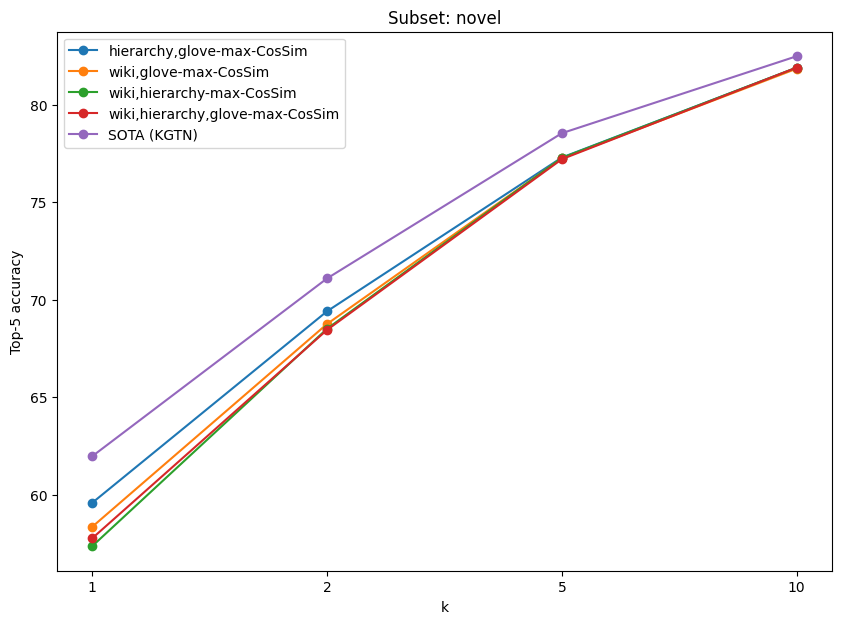

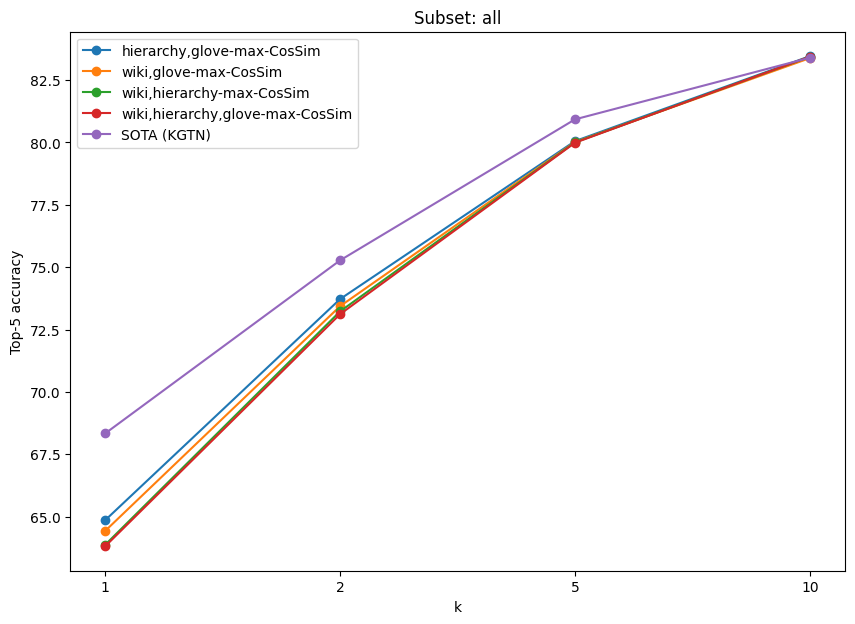

In [22]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(10,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        # plt.yscale('log')
        plt.legend()
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    # plt.show()
    tikzplotlib.save(f"{FIGURES_DIR}/max_{current_type}_cossim.tex")


In [23]:
df[df['type']=='all']

,1,2,5,10,type,label
1,64.858383,73.720710,80.051282,83.455621,all,"hierarchy,glove-max-CosSim"
3,64.429191,73.435897,80.014990,83.379093,all,"wiki,glove-max-CosSim"
5,63.872978,73.226824,80.000789,83.433531,all,"wiki,hierarchy-max-CosSim"
7,63.813018,73.115582,79.986588,83.439053,all,"wiki,hierarchy,glove-max-CosSim"
9,68.336095,75.273373,80.923866,83.396450,all,SOTA (KGTN)
